## A Probabilistic Policy
We develop a policy function that maps a board to a probabilistic distribution over good actions. We use the heuristic scoring system from ```HeuristicPolicy.py``` and ```Heuristic.py```. The trick is to have a prioritized approach that considers the criticality categories top down. Only if there's no field belonging to a higher category, then any lower category or the original score can be considered. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from wgomoku import (
    GomokuBoard, Move, StochasticMaxSampler, HeuristicGomokuPolicy, 
    ThreatSearch, Heuristics, GomokuTools as gt)


In [3]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

In [4]:
h = Heuristics(kappa=3.0)

In [5]:
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, threat_search=ThreatSearch(5,3))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10);

The probabilistic distribution is provided by ```HeuristicGomokuPolicy.probas```

In [6]:
import inspect
lines = inspect.getsource(HeuristicGomokuPolicy.probas)
print(lines)

    def probas (self, board, style):
        """    
        Returns the (suggested) probabilities for a move to be taken.
        In case, masks all but the positions belonging to the most critical category. 
        Params:
        board: a gomoku board.
        style: 0=aggressive, 1=defensive, 2=mixed
        In non-critical situations, style = 0 looks at offensive options only,
        style = 1 looks at defensive options only and style = 2 considers both aspects
        equally.
        """
        scores = board.get_clean_scores()
        to_move = 1 - board.current_color
        o = scores[to_move]
        d = scores[1 - to_move]

        criticals = [lambda: o > 7.0, lambda: d > 7.0,
                     lambda: o == 7.0, lambda: d == 7.0,
                     lambda: o == 6.9, lambda: d == 6.9]

        for crit in criticals:
            field = crit()
            if field.any():
                return field / field.sum()

        if style == 0:
            noncrit = scores[t

-5.050153242075339

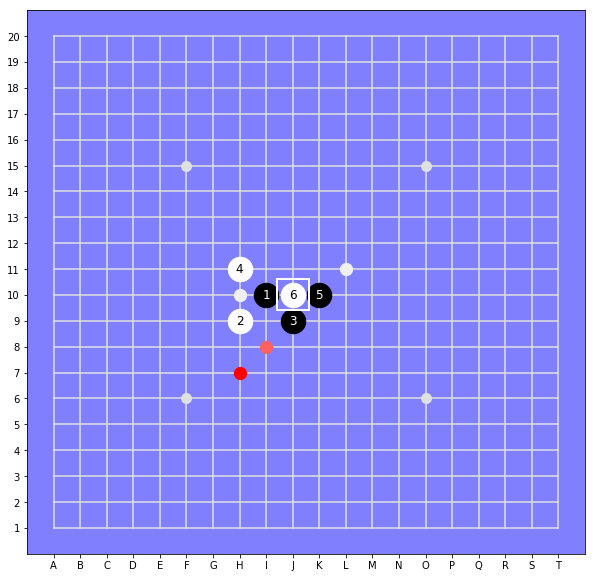

In [7]:
board.display(probas=lambda x: p.probas(x, 2))
board.get_value(True)

In [8]:
board.set(H, 7);

-30.72068268501276

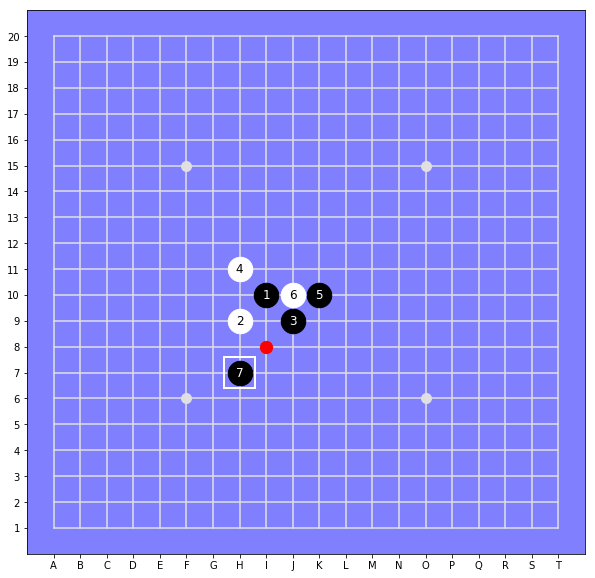

In [9]:
board.display(probas=lambda x: p.probas(x, 1))
board.get_value(True)

---
### Let the games begin!
We use a ```StochasticMaxSampler``` to sample from the board's distribution function . The idea behind the below self-play is that the players follow a common policy that handles critical situations appropriately and suggests kind of value-based moves, otherwise. Both parties check the field for potential threat sequences before they engage in rather loose (bias=0.5) tactical moves.

In [45]:
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, 
                          threat_search=ThreatSearch(6,5))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10);
ts = ThreatSearch(max_depth=4, max_width=5)

Black lost.
CPU times: user 3.4 ms, sys: 0 ns, total: 3.4 ms
Wall time: 3.06 ms


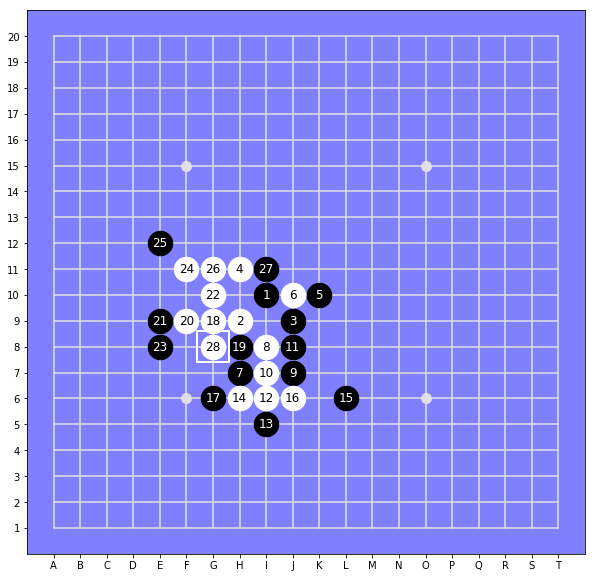

In [57]:
def play(board, p, N, ts):
    colors = ['Black', 'White']
    for i in range(N):
        moves, won = ts.is_tseq_won(board)
        if won:
            x, y = moves[0]
            #print ("Thread sequence: %s: " % moves)
        else:
            probas = p.probas(board, 2)
            sampler = StochasticMaxSampler(np.ndenumerate(probas), bias=0.5, topn=5)
            move = sampler.draw()
            x, y = gt.m2b(move, size=20)
        board.set(x,y)

        status = board.game_state()
        if status == 1: 
            print("%s wins." % colors[1 - board.current_color])
            break
        elif status == -1: 
            print("%s lost." % colors[1 - board.current_color])
            break
%time play(board, p, 40, ts)
board.display()

In [58]:
colors = ['Black', 'White']
status = board.game_state()
winner = int((status+1)/2) ^ board.current_color # wanna check the boolean table?
board.current_color, status, winner

(1, -1, 1)

In [59]:
gt.stones_to_string(board.stones)

'i10h9j9h11k10j10h7i8j7i7j8i6i5h6l6j6g6g9h8f9e9g10e8f11e12g11i11g8'

In [60]:
games = []
ts = ThreatSearch(max_depth=6, max_width=5)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, threat_search=ts)
for i in range(40):
    board = GomokuBoard(h, N=20, disp_width=10)
    board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10);
    play(board, p, 40, ts)
    status = board.game_state()
    winner = int((status+1)/2) ^ board.current_color 
    string = gt.stones_to_string(board.stones)
    games.append([string, winner])

White wins.
White wins.
White wins.
Black wins.
White wins.
Black wins.
Black wins.
White wins.
White wins.
White wins.
Black wins.
White wins.
Black wins.
Black wins.
White wins.
White wins.
Black wins.
White wins.
White wins.
Black wins.
Black wins.
Black wins.
White lost.
White wins.
White wins.
Black wins.
White wins.
Black lost.
Black wins.
White wins.
Black wins.
White wins.
White wins.
Black wins.
White wins.
White wins.
Black wins.
Black wins.


In [61]:
games

[['i10h9j9h11k10j10h7i8k6f11g10i11g11h12g13', 1],
 ['i10h9j9h11k10j10m12l11k11i8k8k9h12j7g10l8m7k6l5l10l9i7j8h7g7l7k7i6i5j5i4',
  1],
 ['i10h9j9h11k10j10l11i8j7h10h12h8h7j8k8i9g7', 1],
 ['i10h9j9h11k10j10i8l11i9i7h7g6l9i12k9m9k8k7l7m6l8j8', 0],
 ['i10h9j9h11k10j10h7i8k8f11g10i11g11h12k9', 1],
 ['i10h9j9h11k10j10i8h7h8i7g8j8k7l11i11e8i9i12l7k8n7m7l9m8l8l6m9k9', 0],
 ['i10h9j9h11k10j10l11i8g10k11h8l12m13i11h10j11g11m12f10e10g9g12', 0],
 ['i10h9j9h11k10j10m12l11k11k14k12k9h12n12i12l8m7l10l9', 1],
 ['i10h9j9h11k10j10m12l11i11i8i9h10h12i13h8l9l10e12m10m9n10o10n9n11g10m11k11o11p11o12o9o14o13p9k13k12p13p12q12q8r7p8r8p7p6q13',
  1],
 ['i10h9j9h11k10j10i8l11h7g6h10i11g11l8k9i9g7k11j11', 1],
 ['i10h9j9h11k10j10l11m12h10i8j7k8l8g10j13f11e12f9e8g9e9g11i11', 1],
 ['i10h9j9h11k10j10h10l11i8i11j11h7l8i9m8l9k8j8m6l7o8n8n7p9k4l5k7k9m9j6', 0],
 ['i10h9j9h11k10j10l11i8k6g10f11f9i12e8d7g9e9g8g7', 1],
 ['i10h9j9h11k10j10m12l11h10j11k11i11k9k8k12k13m9l9j12l12', 0],
 ['i10h9j9h11k10j10l11m12i11i8k8k6j7l7l9i6

In [62]:
import pandas as pd

In [63]:
df = pd.DataFrame(games, columns=['game', 'winner'])

In [64]:
df

,game,winner
0,i10h9j9h11k10j10h7i8k6f11g10i11g11h12g13,1
1,i10h9j9h11k10j10m12l11k11i8k8k9h12j7g10l8m7k6l...,1
2,i10h9j9h11k10j10l11i8j7h10h12h8h7j8k8i9g7,1
3,i10h9j9h11k10j10i8l11i9i7h7g6l9i12k9m9k8k7l7m6...,0
4,i10h9j9h11k10j10h7i8k8f11g10i11g11h12k9,1
5,i10h9j9h11k10j10i8h7h8i7g8j8k7l11i11e8i9i12l7k...,0
6,i10h9j9h11k10j10l11i8g10k11h8l12m13i11h10j11g1...,0
7,i10h9j9h11k10j10m12l11k11k14k12k9h12n12i12l8m7...,1
8,i10h9j9h11k10j10m12l11i11i8i9h10h12i13h8l9l10e...,1
9,i10h9j9h11k10j10i8l11h7g6h10i11g11l8k9i9g7k11j11,1


In [65]:
df.to_csv("self_play_data/startwith_i10h9j9h11k10j10_style_2_ts_65.csv")